---

# Forecasting Fruit Price using StemGNN
### Revision 23.02.28

---

## 1 Environment

In [1]:
import torch
print(torch.__version__, torch.cuda.is_available())
# 1.7.1+cu110 True

1.7.1+cu110 True


In [2]:
#import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F

from datetime import datetime
import pandas as pd
import numpy as np
import argparse, json, time, os, sys, importlib, itertools
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import warnings
warnings.filterwarnings(action='ignore')

#from models.handler import train, test
sys.path.insert(0, './models')
import handler
importlib.reload(handler)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## 2 Data Check

In [3]:
#with Price Data
price_dataset = pd.read_csv('./dataset/price_dataset.csv',index_col=[0])
price_dataset.to_csv("./dataset/pre_price.csv", header=True, index=False)
price_dataset.tail(5)

,potato,lettuce,onion,cucumber,high_tmp,rain_amt,avg_humid,avg_tmp,low_tmp,dtt,calweek
date,,,,,,,,,,,
2022.3.28,43000,17700,8625,57000,15.1,0.0,35.6,8.2,1.5,13.6,202213
2022.3.29,52300,17000,9975,57700,15.6,0.0,52.9,9.7,3.3,12.3,202213
2022.3.30,52300,18000,9975,49700,15.7,0.4,76.5,10.8,5.9,9.8,202213
2022.3.31,60000,20500,9975,46200,14.7,0.0,63.5,10.9,7.6,7.1,202213
2022.4.1,60000,21000,9975,38200,14.9,0.0,50.5,9.2,4.5,10.4,202213


## 3 Data Smoothing

In [4]:
# Data Smoothing using Rolling Average
plot_result = [price_dataset]
for i in [7, 14, 21, 28]: # 7d, 14d, 21d, 28d
    rolling_tmp = pd.DataFrame(price_dataset.rolling(i).mean()).dropna()
    for j in range(rolling_tmp.shape[1]):
        if j in range(0,5):
            rolling_tmp.iloc[:,j] = rolling_tmp.iloc[:,j].round(decimals = 0).astype('int')
        if j in range(4,10):
            rolling_tmp.iloc[:,j] = rolling_tmp.iloc[:,j].round(decimals = 1).astype('float64')
    rolling_tmp.iloc[:,10] = rolling_tmp.iloc[:,10].apply(np.ceil).astype('int')
    rolling_tmp.to_csv("./dataset/pre_price_s_"+str(i)+"d.csv", header=True, index=False)
    plot_result.append(rolling_tmp)
plot_result[0].head(3)

,potato,lettuce,onion,cucumber,high_tmp,rain_amt,avg_humid,avg_tmp,low_tmp,dtt,calweek
date,,,,,,,,,,,
2000.1.3,15000,12000,7800,14500,0.1,0.0,54.1,-2.2,-4.6,4.7,200001
2000.1.4,15000,11000,7800,14500,4.3,0.0,48.6,0.3,-4.3,8.6,200001
2000.1.5,15000,10000,7800,14500,4.6,18.4,83.6,2.8,0.1,4.5,200001


## 4 Train

In [5]:
def stemgnn (data, window_size, horizon, train_length, valid_length, test_length) :
    print('Dataset:', data, '| Window_size:',window_size,'| Horizon: ',horizon)
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', type=bool, default=True)
    parser.add_argument('--evaluate', type=bool, default=True)
    parser.add_argument('--dataset', type=str, default=data) #ECG_data
    parser.add_argument('--window_size', type=int, default=window_size)
    parser.add_argument('--horizon', type=int, default=horizon)
    parser.add_argument('--train_length', type=float, default=train_length)
    parser.add_argument('--valid_length', type=float, default=valid_length)
    parser.add_argument('--test_length', type=float, default=test_length)
    parser.add_argument('--epoch', type=int, default=200)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--multi_layer', type=int, default=5)
    #parser.add_argument('--device', type=str, default='cpu')
    parser.add_argument('--device', type=str, default='cuda')
    parser.add_argument('--validate_freq', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--norm_method', type=str, default='z_score')
    parser.add_argument('--optimizer', type=str, default='RMSProp')
    parser.add_argument('--early_stop', type=bool, default=True)
    parser.add_argument('--early_stop_step', type=int, default=20)
    parser.add_argument('--exponential_decay_step', type=int, default=5)
    parser.add_argument('--decay_rate', type=float, default=0.5)
    parser.add_argument('--dropout_rate', type=float, default=0.5)
    parser.add_argument('--leakyrelu_rate', type=int, default=0.2)

    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    data_file = os.path.join('dataset', args.dataset + '.csv')
    data = pd.read_csv(data_file).values
    
    # make dirs
    args.dataset = args.dataset + '_w_'+str(args.window_size)+'_h_'+str(args.horizon)
    result_train_file = os.path.join('output', args.dataset, 'train')
    result_test_file = os.path.join('output', args.dataset, 'test')
    if not os.path.exists(result_train_file):
        os.makedirs(result_train_file)
    if not os.path.exists(result_test_file):
        os.makedirs(result_test_file)

    # split data
    train_ratio = args.train_length / (args.train_length + args.valid_length + args.test_length)
    valid_ratio = args.valid_length / (args.train_length + args.valid_length + args.test_length)
    test_ratio = 1 - train_ratio - valid_ratio
    train_data = data[:int(train_ratio * len(data))]
    valid_data = data[int(train_ratio * len(data)):int((train_ratio + valid_ratio) * len(data))]
    test_data = data[int((train_ratio + valid_ratio) * len(data)):]

    torch.manual_seed(0)
    if args.train:
        try:
            before_train = datetime.now().timestamp()
            _, normalize_statistic = handler.train(train_data, valid_data, args, result_train_file)
            after_train = datetime.now().timestamp()
            print(f'\nTraining took {(after_train - before_train) / 60} minutes')
        except KeyboardInterrupt:
            print('-' * 99)
            print('Exiting from training early')
    if args.evaluate:
        before_evaluation = datetime.now().timestamp()
        handler.test(test_data, args, result_train_file, result_test_file)
        after_evaluation = datetime.now().timestamp()
        #print(f'Evaluation took {(after_evaluation - before_evaluation) / 60} minutes')
    print('-'*30)
    return args

In [6]:
csv_cases = ['pre_price', 'pre_price_s_7d','pre_price_s_14d', 'pre_price_s_21d', 'pre_price_s_28d'] 
window_cases = [15, 30, 45, 60, 90, 180, 270, 360]
horizon_cases = [a+1 for a in range(7)] + [14]
all_cases = list(itertools.product(*[csv_cases,window_cases,horizon_cases]))
print("경우의 수 : %s개 | ex:" %len(all_cases), all_cases[0])

경우의 수 : 320개 | ex: ('pre_price', 15, 1)


In [8]:
for i in all_cases :
    args = stemgnn(data = i[0],
        window_size = i[1],
        horizon = i[2],
        train_length = 7,
        valid_length = 2,
        test_length = 1)

Dataset: pre_price | Window_size: 15 | Horizon:  1
Epoch:0 | Epoch:10 | Epoch:20 | Epoch:30 | Epoch:31 | 
Training took 0.6846506516138713 minutes

Performance on test set: MAPE:  0.61 | MAE: 981.49 | RMSE: 2439.2642|
MAPE of potato : 0.0764 , lettuce : 0.1424 , onion : 0.0911 , cucumber : 0.1102
------------------------------


## 5 Result

In [9]:
Produce = 0
Produce_list = ['Potato', 'Lettuce', 'Onion', 'Cucumber']

[Figure] Smoothing: pre_price | Window:15 | horizon:1


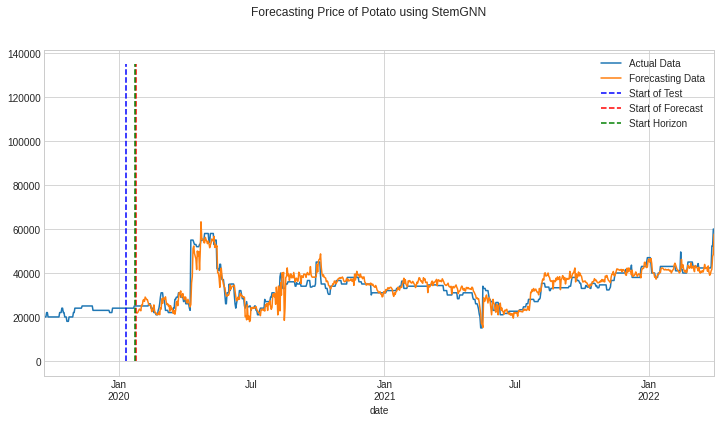

In [10]:
for i in all_cases:
    print('[Figure] Smoothing:',str(i[0])+' | Window:'+str(i[1])+' | horizon:'+str(i[2]))
    
    start_day = 7200
    test_t = plot_result[csv_cases.index(str(i[0]))]#.iloc[:,Produce]
    test_p = pd.read_csv('./output/'+ str(i[0])+'_w_'+str(i[1])+'_h_'+str(i[2]) +'/test/predict.csv', header=None).iloc[:,Produce]
    test_t.index = pd.to_datetime(test_t.index)
    test_p.index = pd.to_datetime((test_t.index)[-(len(test_p)):])

    fig, ax = plt.subplots(figsize=(12,6))
    test_t.iloc[start_day:,Produce].plot(ax=ax, label='Actual Data');
    test_p.plot(ax=ax, label='Forecasting Data');
    ax.vlines((test_t.iloc[:,Produce]).index[int(len(test_t)*(args.train_length+args.valid_length)/10)], 0, max(test_t.iloc[:,Produce]), linestyle='--',color='b',label='Start of Test')
    ax.vlines((test_t.iloc[:,Produce]).index[-(len(test_p))], 0, max(test_t.iloc[:,Produce]), linestyle='--',color='r',label='Start of Forecast')
    ax.vlines((test_t.iloc[:,Produce]).index[int(len(test_t)*(args.train_length+args.valid_length)/10)+(i[1])-2], 0, max(test_t.iloc[:,Produce]), linestyle='--',color='g',label='Start Horizon')

    ax.legend(loc='upper right')
    fig.suptitle('Forecasting Price of ' +Produce_list[Produce]+' using StemGNN')
    plt.show()

---